# Code for generating Fig. 3

## Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from alphashape import alphashape
from matplotlib.collections import LineCollection
import torch
from torch import nn
import tqdm
from sklearn import model_selection
import json
from scipy.spatial import Delaunay
import random
from matplotlib import patches
import matplotlib.colors as colors
from sklearn.model_selection import GroupShuffleSplit
from shapely.geometry import Point
import pickle

#Getting the full manifold data
df = pd.read_csv('no_avg_dataset.csv')

#Getting the alpha shape
z_array = np.concatenate((np.asarray(df["Z0"]).reshape(-1,1), np.asarray(df["Z1"]).reshape(-1,1)), axis = 1)
alpha_shape = alphashape(z_array, alpha = 1)

### Alpha shape code

In [2]:
def plot_alpha_shape(alpha_shape, ax = None):
    if ax is None:
        plt.plot(*alpha_shape.exterior.xy, color='black', linewidth=1,alpha = 0.7, label='Alpha Shape')
        
    else:
        ax.plot(*alpha_shape.exterior.xy, color='black', linewidth=1,alpha = 0.7, label='Alpha Shape')

## Getting RMSDs

In [3]:
seqs = np.unique(df['Sequence'])
ps = np.unique(df["p"])

rmsds = []
coords = []
seq_and_p = []

# Going through each p value for each sequence
for seq in seqs:
    seq_df = df[df["Sequence"] == seq]
    for p in ps:
        p_df = seq_df[seq_df["p"] == p]

        # Averaging coordinate for all runs
        xs = np.array(p_df["Z0"]).reshape(-1,1)
        ys = np.array(p_df["Z1"]).reshape(-1,1)
        avgx = np.mean(xs)
        avgy = np.mean(ys)
        points = np.concatenate((xs, ys), axis = 1)

        # Calculate pairwise distances
        num_points = len(points)
        sum_of_squared_distances = 0
        count = 0

        for i in range(num_points):
            for j in range(i + 1, num_points):
                distance = np.linalg.norm(points[i] - points[j])
                sum_of_squared_distances += distance ** 2
                count += 1

        # Compute the mean of the squared distances
        mean_squared_distance = sum_of_squared_distances / count

        # Compute the root mean square distance
        rms_distance = np.sqrt(mean_squared_distance)

        # Saving the RMSD, the cooresponding seq, p, and coordinate
        rmsds.append(rms_distance)
        seq_and_p.append((seq, p))
        coords.append((avgx, avgy))
                

# Plotting

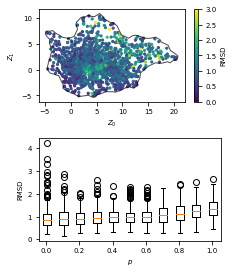

In [4]:
# Fig specs
fig_width_in = 8.3 /2.54  # 8.3cm for single column, 17.1cm for double, divided by 2.54 to convert cm to inches
aspect_ratio = 1.5
fig_height_in = fig_width_in / aspect_ratio
fontsize = 7

# Defining the plot
fig, (ax1, ax2) = plt.subplots(figsize = (fig_width_in, fig_height_in*2), nrows = 2, ncols = 1)


# Plot a) 
plot_alpha_shape(alpha_shape, ax = ax1)
coords = np.vstack(coords)
scatter = ax1.scatter(coords[:,0], coords[:,1], c = rmsds,cmap = 'viridis', s = 5, vmax = 3, vmin = 0)
ax1.set_aspect('equal')

cbar = fig.colorbar(scatter, ax = ax1, shrink = 0.9)
cbar.ax.tick_params(labelsize=fontsize) 
cbar.set_label("RMSD", fontsize = fontsize)

ax1.set_xlabel(r'$Z_0$', fontsize = fontsize)
ax1.set_ylabel(r'$Z_1$', fontsize = fontsize)
ax1.tick_params(axis = 'x', labelsize = fontsize)
ax1.tick_params(axis = 'y', labelsize = fontsize)

# Plot b)
rmsds_seq_and_p = np.concatenate((np.array(rmsds).reshape(-1,1), np.array(seq_and_p).reshape(-1,2)), axis = 1)
all_rmsd_data = []

# Separating RMSD data by p
for p in ps:
    val = str(p)
    filtered_data = rmsds_seq_and_p[rmsds_seq_and_p[:,2] == val]
    p_rmsd = [float(point) for point in filtered_data[:,0]]
    all_rmsd_data +=[p_rmsd]

str_ps = [float(val) for val in ps]

# Creating boxplot
boxplot = ax2.boxplot([arr for arr in all_rmsd_data], labels = [f'{value:.1f}' for value in str_ps])

# Getting boxplot positions
box_positions = [box.get_xdata().mean() for box in boxplot['boxes']]

# Defining x tick values
even_values = [0, 0.2, 0.4, 0.6, 0.8, 1]   

# Setting new x tick values
even_x_ticks = [box_positions[i] for i, value in enumerate(ps) if value in even_values]
ax2.set_xticks(even_x_ticks)
ax2.set_xticklabels([f'{value:.1f}' for value in even_values])

# Set the labels and title
ax2.set_xlabel(r'$p$', fontsize = fontsize )
ax2.set_ylabel("RMSD", fontsize = fontsize)
ax2.tick_params(axis = 'x', labelsize = fontsize)
ax2.tick_params(axis = 'y', labelsize = fontsize)

# Adjusting subplot locations
left = 0.1
width = 0.8
ax1.set_position([left, 0.55, width, 0.35])
ax2.set_position([left, 0.1, width, 0.35])
fig.subplots_adjust(hspace = 0.3)

fig.show()


### Save figure

In [8]:
fig.savefig('combined_rmsd_plots_fig_3.pdf', dpi = 600, bbox_inches = 'tight')